# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


## Introduction

### Imports

In [ ]:
# !pip install --upgrade torch==1.0.1
# !pip install --upgrade torch==1.1.0


     |████████████████████████████████| 676.9MB 19kB/s 
  Found existing installation: torch 1.0.1
    Uninstalling torch-1.0.1:
      Successfully uninstalled torch-1.0.1


In [3]:
import matplotlib.pyplot as plt # 2D plots
%matplotlib inline
import numpy as np
import sklearn

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.models as models
from torchvision import datasets
from torchvision.transforms import transforms

from torchsummary import summary

from IPython.display import clear_output
from IPython.core.debugger import set_trace # only for debugging
import itertools # plot_conf_mx
from itertools import chain # Used in test_model()
import time, sys
from tqdm import tqdm_notebook as tqdm # Interactive loops

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# if you're running in google colab
# 1. Comment this
# %reload_ext autoreload
# # reload modules before executing each line
# %autoreload 2

# 2. Uncomment this
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


print('NumPy version: \t\t%s' % np.__version__)
print('PyTorch version: \t%s' % torch.__version__)

import warnings # Disable annoying messages
warnings.filterwarnings('ignore')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
NumPy version: 		1.16.3
PyTorch version: 	1.1.0


### Constants

In [ ]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook
# If true, save model parameters to GDrive
COLAB = True

# Path to a directory with image dataset and subfolders for training, validation and final testing
if COLAB:
    ROOT_DIR = "/content/gdrive/My Drive/Colab Notebooks/"
else:
    ROOT_DIR = r'../'
DATA_PATH = ROOT_DIR + "data/" # PATH TO THE DATASET
MODELS_PATH = ROOT_DIR + "models/" # PATH TO FOLDER w\ pre-trained models weights

# Number of threads for data loader
NUM_WORKERS = 4

# % of train dataset used for validation
ratio = 0.2

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 64

# Epochs: number of passes over the training data
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 512

# Images mean and std channelwise. [0,1] -> [-1,1]
image_mean = [0.4914, 0.4822, 0.4465] #
image_std  = [0.2023, 0.1994, 0.2010] # 
# image_mean = [0.485, 0.456, 0.406] # ImageNet
# image_std  = [0.229, 0.224, 0.225] # ImageNet

# Number of classes in the dataset
NUM_CLASSES = 200

# Random seed for reproducible results
SEED = 1244
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
print('Root dir: {} \nData dir: {} \nModels dir: {}'.format(ROOT_DIR, DATA_PATH, MODELS_PATH))

Root dir: /content/gdrive/My Drive/Colab Notebooks/ 
Data dir: /content/gdrive/My Drive/Colab Notebooks/data/ 
Models dir: /content/gdrive/My Drive/Colab Notebooks/models/


### Data preprocessing

#### Loading data

In [6]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU

# 2. uncomment this:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py -O tiny_img.py
  
# 3. comment this
# sys.path.insert(0, DATA_PATH)

from tiny_img import download_tinyImg200
download_tinyImg200(DATA_PATH)

--2019-05-15 18:00:48--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3378 (3.3K) [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]   3.30K  --.-KB/s    in 0s      

2019-05-15 18:00:49 (64.5 MB/s) - ‘tiny_img.py’ saved [3378/3378]

/content/gdrive/My Drive/Colab Notebooks/data/tiny-imagenet-200.zip


#### Data loaders

In [ ]:
## Use 'aug = True' to augment image data
aug = True

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=image_mean, std=image_std)
])

complex_transform = transforms.Compose([
#     transforms.Pad(4),
    transforms.RandomAffine(10, translate=(0.05,0.05), 
                            scale=(0.95,1.05)),
    transforms.RandomCrop((SIZE_H, SIZE_W)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

# Use 100k examples for training and validation (and testing). There is also 10k images in tiny-imagenet-200/test folder.
dataset = datasets.ImageFolder('tiny-imagenet-200/train', 
                               transform=complex_transform if aug else transform)

train_size, val_size = len(dataset) - int(ratio * len(dataset)), int(ratio * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size , val_size])

test_dataset, val_dataset = torch.utils.data.random_split(val_dataset, 
                                                          [val_size - val_size//2, val_size // 2])
#Save some data for final TEST evaluation
# test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/test', transform=transform)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                              shuffle=True,  num_workers=NUM_WORKERS)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                                            shuffle=True, num_workers=NUM_WORKERS)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                                             shuffle=False,  num_workers=NUM_WORKERS)

Count mean and std for each channel. Should be done once for every new dataset

In [ ]:
# # Count mean for each channel. Assume t.shape == (batch_size, channels, h, w)
# image_mean = torch.stack([torch.mean(t, (0,2,3)) for t, c in train_batch_gen])
# image_mean = torch.mean(image_mean, 0)

# # Count std for each channel. Assume t.shape == (batch_size, channels, h, w)
# image_std = torch.stack([torch.sqrt(
#         torch.mean((t - torch.mean(t, (0,2,3), keepdim=True))**2, (0,2,3))) for t, c in train_batch_gen])
# image_std = torch.mean(image_std, 0)
# print(image_mean, image_std)

#### Sanity check

80000 10000 10000


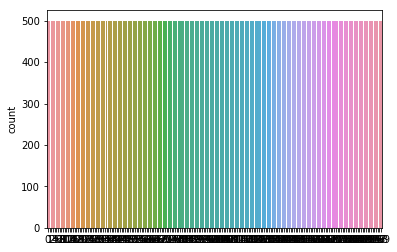

In [9]:
print(len(train_batch_gen.dataset), len(val_batch_gen.dataset), len(test_batch_gen.dataset))

# Check that classes are balanced
import seaborn as sns
g = sns.countplot(train_dataset.dataset.targets) #.numpy()

In [ ]:
def plot_from_batch_generator(batch_gen, grid_size=4, normalize=False):
    """
    Plots :grid_size: images from :batch_gen:
    If :normalize: = True uses precomputed mean and std
    """
    
    # Get a batch of data
    data_batch, label_batch = next(iter(train_batch_gen))
    # Make a grid from batch
    imgs = torch.reshape(data_batch[:grid_size * grid_size], (-1, 3, SIZE_H, SIZE_W))
    grid = torchvision.utils.make_grid(imgs, nrow=grid_size)
 
    # convert to numpy.ndarray and change axes order [C, H, W] -> [H, W, C]
    grid_ndarray = np.transpose(grid.numpy(), [1, 2, 0])

   # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()     
    if normalize:
      src = np.clip(image_std * grid_ndarray + image_mean, 0, 1)
    else:
      src = np.clip(grid_ndarray, 0, 1)
    
    plt.figure(figsize=(6,6))
    plt.title("Training Images")
    plt.imshow(src)
    plt.axis("off")


    
#     class_names = batch_gen.dataset.classes
#     title=['Label = %d (%s)' % (x, class_names[x]) for x in label_batch]

#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated'



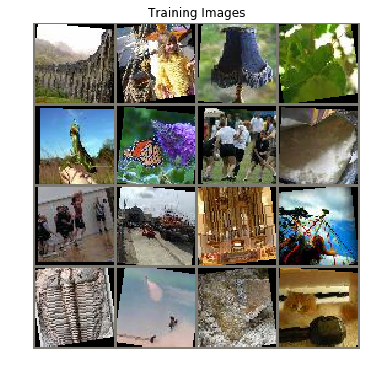

In [11]:
# Let's take a look at our data
plot_from_batch_generator(train_batch_gen, normalize=True)

### Models

In [ ]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

      
def weights_init(m):
    """kaiming_normal
    usage: model.apply(weights_init)"""
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, a=0.01, nonlinearity='leaky_relu')
        torch.nn.init.zeros_(m.bias)

#### Dense and CNN net
Used as a baseline

In [ ]:
class BaselineDenseNet(nn.Module):
    
    def __init__(self):
        super(BaselineDenseNet, self).__init__()
        
        # One way to define network - set a bunch of layers using nn.Sequential
        self.model = nn.Sequential()

        # reshape from "images" to flat vectors
        self.model.add_module('flatten', Flatten())

        # dense "head"
        self.model.add_module('linear1', nn.Linear(3 * 64 * 64, 1024))
        self.model.add_module('linear2', nn.Linear(1024, 512))
        self.model.add_module('dropout0', nn.Dropout(0.05)) 
        self.model.add_module('linear3', nn.Linear(512, 256))
        self.model.add_module('dropout1', nn.Dropout(0.05))
        self.model.add_module('linear4', nn.Linear(256, 64))
        self.model.add_module('dropout2', nn.Dropout(0.05))
        self.model.add_module('dense1_relu', nn.ReLU())
        self.model.add_module('dense2_logits', nn.Linear(64, 200)) # logits for 200 classes

        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
class LeNet(nn.Module):
    """
    The simplest CNN arcitecture from Yan LeCun (except ReLU and BatchNorm)
    """
    
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Another way is to define all modules inside nn.Sequential
        # _ x 3 x 64 x 64
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            # _ x 32 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 32 x 32 x 32
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            # _ x 64 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 64 x 16 x 16
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            # _ x 128 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            # _ x 128 x 8 x 8            
        )

        self.fc = nn.Sequential(
            # this converts our 3D feature maps to 1D feature vectors
            Flatten(),
            # _ x 128 * 8 * 8 
            nn.Linear(128 * 8 * 8, EMBEDDING_SIZE),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            # _ x EMBEDDING_SIZE
            nn.ReLU(),
            nn.Dropout(0.5),       
        )

        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            # _ x NUM_CLASSES
            nn.Sigmoid()
        )

        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Third way - describe layers and call them explicitly during `forward` pass
       
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        
        # "flatten" the data
        self.flat = Flatten()
        
        # last fully-connected layer, used to create embedding vectors
        self.fc1 = nn.Linear(128, EMBEDDING_SIZE)
  
        # logits for NUM_CLASSES=2 classes
        self.fc_logits = nn.Linear(EMBEDDING_SIZE, NUM_CLASSES)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        # global average pooling
        # 20 - oставшийся размер картинки, должно быть 128 каналов
        x = F.avg_pool2d(F.relu(self.conv3(x)), 20)
        x = self.flat(x)

        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc_logits(x))
        return x


#### Better CNN's (Custom + ResNet)

In [ ]:
class GoodCNN(nn.Module):
    # VGG like architecture
    def __init__(self):
        super(GoodCNN, self).__init__()
        
        activation = nn.LeakyReLU()
        # _ x 3 x 64 x 64
        model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            # _ x 32 x 64 x 64
            nn.BatchNorm2d(32),
            activation,
            nn.MaxPool2d(2, stride=2),
            # _ x 32 x 32 x 32
            nn.Dropout2d(0.3),
            
            nn.Conv2d(32, 64, 3, padding=1),
            # _ x 64 x 32 x 32
            nn.BatchNorm2d(64),
            activation,
            nn.MaxPool2d(2, stride=2),
            # _ x 64 x 16 x 16
            nn.Dropout2d(0.3),
            
            nn.Conv2d(64, 128, 3, padding=1),
            # _ x 128 x 16 x 16
            nn.BatchNorm2d(128),
            activation,
            nn.AvgPool2d(16)
            # _ x 128 x 1 x 1     
        )
        
        fc = nn.Sequential(
            Flatten(),
            # _ x 128
            nn.Linear(128, EMBEDDING_SIZE),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            activation,
            nn.Dropout(0.3)
        )
        pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
        self.main = nn.Sequential(model, fc, pred)


    def forward(self, input):
        output = self.main(input)
        return output


In [ ]:
# Torch implementation of ResNet https://arxiv.org/abs/1512.03385
DOWNSAMPLE_COEF =2 
def x_downsample(in_channels):
     return nn.Conv2d(in_channels, 
                      in_channels * DOWNSAMPLE_COEF,
                      kernel_size=1,
                      stride=DOWNSAMPLE_COEF,
                      bias=False)

class ResidualBlock(nn.Module):
    """
    Base building block for ResNet convolutions.
    :downsample: increase number of in_channels by DOWNSAMPLE_COEF
    :skip_connection: add block input to block output. False == no `residual` part
    Input size [B x in_cnannels x H x W]
    Output size if downsample: 
                    [B x in_channels * DOWNSAMPLE_COEF x H // 2 x W // 2]
                else:
                    [B x in_channels x H x W]
    
    """
    DOWNSAMPLE_COEF = 2
    
    def __init__(self, in_channels, downsample=False, skip_connection=True):
        super(ResidualBlock, self).__init__()
        
        self.skip_connection = skip_connection
        self.downsample = downsample
        coef = DOWNSAMPLE_COEF if downsample else 1
        out_channels = in_channels * coef
        
        if downsample and skip_connection:
            #downsample shortcut branch if needed
            self.short_conv = x_downsample(in_channels) 
 
        self.block = nn.Sequential(
            # stride=2 if downsample else 1
            #conv3x3
            nn.Conv2d(in_channels, out_channels, 
                      stride=coef,
                      kernel_size=3, 
                      padding=1, 
                      bias=False),            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 
                      kernel_size=3, 
                      padding=1, 
                      bias=False),   
            nn.BatchNorm2d(out_channels)
        )
            
    def forward(self, x):
        ### forward блок с учетом флагов downsample и skip_connection
        skip = x
        out = self.block(x)
        
        if self.skip_connection:
            if self.downsample:
                skip = self.short_conv(skip)
            out = torch.add(out, skip)
        out = nn.ReLU()(out)
        
        return out

# doesn't work =(
class ResidualBottleneckBlock(nn.Module):
    """
    Decrease in_channels by BOTTLENECK_COEF, then convolve and
    increase again.
    :downsample: increase number of in_channels by DOWNSAMPLE_COEF
    :skip_connection: add block input to block output. False == no `residual` part
    Input size [B x in_cnannels x H x W]
    Output size if downsample: 
                    [B x in_channels * DOWNSAMPLE_COEF x H // 2 x W // 2]
                else:
                    [B x in_channels x H x W]
    """
    
    DOWNSAMPLE_COEF = 2
    BOTTLENECK_COEF = 4
     
    def __init__(self, in_channels, downsample=False, skip_connection=True):
        super(ResidualBottleneckBlock, self).__init__()
        
        self.skip_connection = skip_connection
        self.downsample = downsample
        coef = DOWNSAMPLE_COEF if downsample else 1 
        bneck_channels = in_channels * coef // self.BOTTLENECK_COEF
        out_channels = in_channels * coef
        
        ### 
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels,
                      bneck_channels, 
                      kernel_size=1, 
                      padding=1, # (0,0) 
                      bias=False),
            
            nn.BatchNorm2d(bneck_channels),
            nn.ReLU(),
            
            nn.Conv2d(bneck_channels, bneck_channels, 
                      stride=coef,
                      kernel_size=3, 
                      padding=1, 
                      bias=False), 
            nn.BatchNorm2d(bneck_channels),
            nn.ReLU(),
            
            nn.Conv2d(bneck_channels, 
                      out_channels,
                      kernel_size=1, 
                      bias=False),
            nn.BatchNorm2d(out_channels)
        )

        if downsample and skip_connection:
            #downsample shortcut branch if needed
            self.short_conv = x_downsample(in_channels) 

            
    def forward(self, x):
        ###forward блок с учетом флагов downsample и skip_connection
        skip = x
        
        out = self.bottleneck(x)

        if self.skip_connection:
            if self.downsample:
                skip = self.short_conv(skip)
            out = torch.add(out, skip)
        out = nn.ReLU()(out)

        return out
      
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        
        # _ x 3 x 64 x 64
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            # _ x 64 x 64 x 64
            ResidualBlock(64),
            ResidualBlock(64, downsample=True),
            # _ x 128 x 32 x 32
            
            ResidualBlock(128),
            ResidualBlock(128, downsample=True),
            # _ x 256 x 16 x 16
            
            ResidualBlock(256),
            ResidualBlock(256, downsample=True),
            # _ x 512 x 8 x 8            
            
            ResidualBlock(512),
            ResidualBlock(512,),
            # _ x 512 x 8 x 8
            
            nn.AvgPool2d(8),
            # _ x 512 x 1 x 1

        )
        
        self.fc = nn.Sequential(
            Flatten(),
            # _ x 512
            nn.Linear(512, EMBEDDING_SIZE * 2),
            nn.BatchNorm1d(EMBEDDING_SIZE * 2),
            nn.ReLU()
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE * 2, NUM_CLASSES),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
       
        return x

In [ ]:
    def weight_init(self, _type='kaiming'):
        if _type == 'kaiming':
            for ms in self._modules:
                kaiming_init(self._modules[ms].parameters())


def xavier_init(ms):
    for m in ms:
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('relu'))
            if m.bias.data:
                m.bias.data.zero_()
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.weight.data.fill_(1)
            if m.bias.data:
                m.bias.data.zero_()


def kaiming_init(ms):
    for m in ms:
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.kaiming_uniform(m.weight, a=0, mode='fan_in')
            if m.bias.data:
                m.bias.data.zero_()
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.weight.data.fill_(1)
            if m.bias.data:
                m.bias.data.zero_()

#### Models check

In [18]:
# base_dence = BaselineDenseNet().to(device)
# summary(base_dence, (3, SIZE_H, SIZE_W))

# lenet = LeNet().to(device)
# summary(lenet, (3, SIZE_H, SIZE_W))

## simplecnn = SimpleCNN().to(device)
## summary(simplecnn, (3, SIZE_H, SIZE_W))

# goodcnn = GoodCNN().to(device)
# summary(goodcnn, (3, SIZE_H, SIZE_W))

resnet = ResNet().to(device)
summary(resnet, (3, SIZE_H, SIZE_W))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
            Conv2d-2           [-1, 64, 64, 64]          36,864
       BatchNorm2d-3           [-1, 64, 64, 64]             128
              ReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
     ResidualBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 32, 32]          73,728
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,456
      BatchNorm2d-12          [-1, 128, 32, 32]             256
           Conv2d-13          [-1, 128, 32, 32]           8,192
    ResidualBlock-14          [-1, 128,

## Train/Test loops and useful functions

#### Useful functions

In [ ]:
def lr_finder(model, train_batch_generator, opt, lr_start=1e-6, lr_end=1e1, beta=0.99, plot=True):
    """
    Search for optimal learning rate and plot it's landscape
    Used: docs.fast.ai/callbacks.one_cycle.html and
          sgugger.github.io/the-1cycle-policy.html
    Usage: _, _ = lr_finder(model, batch_gen, opt)

    """
    loss_history, lr_history= [], []
    i, avg_loss, best_loss = 0, 0., float('inf')
    
    criterion = nn.CrossEntropyLoss()
    
    # Number of iterations for one epoch
    N = len(train_batch_generator)
    # Evenly distribute lr samples on log scale
    q = (lr_end / lr_start) ** (1/N)
    lr = lr_start
    
    optimizer = opt
    optimizer.param_groups[0]['lr'] = lr
    
    for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Searching'):
        i += 1
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute loss, calc grads, perform optimizer step and zero the grads
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        #Smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**i)
        
        #Stop if the loss is exploding
        if i > 1 and smoothed_loss > 4 * best_loss:
            return loss_history, lr_history, best_lr 
          
        #Record the best loss
        if smoothed_loss < best_loss or i==1:
            best_loss = smoothed_loss
            best_lr = lr
            
        #Store the values
        loss_history.append(smoothed_loss)
        lr_history.append(np.log10(lr))
        
        #Do optimizer step
        loss.backward()    

        optimizer.step()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #Update the lr for the next step
        lr *= q
        optimizer.param_groups[0]['lr'] = lr
        
    if plot:
        fig, ax = plt.subplots(1,2)
        ax[0].plot(lr_history,loss_history)
        ax[0].set_xlabel('LR')
        ax[0].set_ylabel('Loss')
        
        ax[1].plot([10 ** x for x in lr_history])
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('LR')
        
    return loss_history, lr_history, best_lr

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_logs(logs):
    """Usage: plot_logs(custom_obj[0])"""
    plt.subplot(1, 2, 1)
    plt.plot(logs['epoch'], logs['val_loss'],'g-', label='validation')
    plt.plot(logs['epoch'], logs['train_loss'], label = 'train')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(logs['epoch'], logs['val_accuracy'],'g-')
    plt.xlabel('Epoch #')
    plt.ylabel('Validation accuracy')

def load_model(model, model_name):
    """Looks for given model_name in MODELS_PATH dir"""

    # # Try to load previosly trained model first
    try:
        with open(MODELS_PATH + model_name, 'rb') as f: model = torch.load(f)
        print("Loaded succesfully!")
    except (FileNotFoundError, ) as e:
        print("Pre-trained model not found. Err msg: '{}' ".format(e.args[-1]))

    model.to(device)
    acc, _ = test_model(model, val_batch_gen, verbose=False, conf_mx=False)  
    print("Model validation accuracy = {:.2f}%".format(acc * 100))

    #Print model for debugging
#     summary(model, (1, SIZE_H, SIZE_W))

    return model

#### Train/ Test

In [ ]:
def train_model(model, train_batch_generator, val_batch_generator, 
                opt=None, scheduler=None, log_history=None, ckpt_name=None, n_epochs=EPOCH_NUM, 
                annealing=False, verbose=False):
    """Training function
    opt: optimizer, default is SGD
    log_history: to continuie trainig without losing history
    ckpt_name: saves model to disk
    
    """
    if scheduler:
        annealing=True
        
    if log_history:
        logs = log_history
        start_epoch = logs['epoch'][-1]
    else:
        logs = {'epoch': [], 'train_loss': [], 'val_loss': [],
            'val_accuracy': [],'top_val_accuracy' : 0, 'lr': []}
        start_epoch = 0
      
    
    best_model = None
    iteration = 0
    top_val_accuracy = 0
    
    if opt:
        optimizer=opt
    else:
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=0.001, 
                                    weight_decay=0.0001, 
                                    momentum=0.9)
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.NLLLoss(reduction='mean')

    for epoch in range(n_epochs):
        train_loss = []
        val_loss = []
        val_accuracy = []
        start_time = time.time()
        
        
        # TRAIN
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training'):
            # move data to target device
            assert len(X_batch) == len(y_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()    
            optimizer.step()
            train_loss.append(loss.cpu().data.numpy())
            

        # TEST / VALIDATE
        val_accuracy, val_loss = test_model(model, val_batch_generator, criterion=criterion)
        if annealing: scheduler.step(val_loss)
        
           
        clear_output(wait=True)
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        

        train_loss_value = np.mean(train_loss)
        val_accuracy_value = np.mean(val_accuracy) * 100
        
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_value))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy_value))
        
        #Crutch to add parameter to the model
#         model.register_buffer('val_accuracy', torch.Tensor([val_accuracy_value]))
        
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            print('top val accuracy: %.3f' % top_val_accuracy)
            #save checkpoint of the best model to disk
            with open(MODELS_PATH + ckpt_name, 'wb') as f: torch.save(model, f)
        
        logs['epoch'].append(epoch + start_epoch)
        logs['train_loss'].append(train_loss_value)
        logs['val_loss'].append(val_loss)
        logs['val_accuracy'].append(val_accuracy)
        logs['lr'].append(optimizer.param_groups[0]['lr'])

        
        custom_objects = (logs, )
        
    # Load best model found during trainig
    if ckpt_name is not None:
        with open(MODELS_PATH + ckpt_name, 'rb') as f: best_model = torch.load(f)
 
    return best_model, opt, custom_objects

In [ ]:
def test_model(model, test_batch_generator, criterion=None, subset='test', 
               verbose=False, conf_mx=True, errors=False):
    """
    Compute model performance on test/validation dataset
    :criterion: used to compute loss
    """
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc, test_batch_loss = [], []
    y_true, y_predicted = [], []
    incorrect = [] # save all errors here
    for X_batch, y_batch in test_batch_generator:
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute logits
        logits = model(X_batch)
        # compute loss if needed
        if criterion is not None:
            loss = criterion(logits, y_batch)
            test_batch_loss.append(loss.cpu().data.numpy())
        
        # get idx of the max element in a row. 
        y_pred = logits.max(1)[1].data
        y_pred_confidence = logits.max(1)[0].data

        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
        y_true.append(y_batch.cpu().numpy())
        # save for classification_report
        y_predicted.append(y_pred.cpu().numpy())

    test_accuracy = np.mean(test_batch_acc)
    test_loss = np.mean(test_batch_loss)
        

    if verbose:
        print("Results:")
        print("  {} accuracy:\t\t{:.2f} %\n".format(subset, test_accuracy * 100))
        

        #get the predictions for the test data
        y_true = list(chain.from_iterable(y_true))

        y_predicted = list(chain.from_iterable(y_predicted))
        print(sklearn.metrics.classification_report(y_true, y_predicted))
                                                    

        #get the indices to be plotted
        incorrects = np.nonzero([x != y for x,y in zip(y_predicted, y_true)])[0] 
        
        if errors:
          plt.figure(figsize=(8,8))
          for i, incorrect in enumerate(incorrects[0:9]):
              plt.subplot(3,3,i+1)

              plt.imshow(test_batch_generator.dataset.data[incorrect], cmap='gray')
              plt.title("Pred: {}, Tr: {}".format(labels[y_predicted[incorrect]], 
                                                          labels[y_true[incorrect]]))
              plt.tight_layout()
              plt.axis('off')
        
        if conf_mx:
          # compute the confusion matrix
          confusion_mtx = sklearn.metrics.confusion_matrix(y_true, y_predicted) 
          # plot the confusion matrix
          plot_confusion_matrix(confusion_mtx, classes = labels) 


        if test_accuracy * 100 > 70:
            print("U'r freakin' amazin'!")
        elif test_accuracy * 100 > 50:
            print("Achievement unlocked: 110lvl Warlock!")
        elif test_accuracy * 100 > 40:
            print("Achievement unlocked: 80lvl Warlock!")
        elif test_accuracy * 100 > 30:
            print("Achievement unlocked: 70lvl Warlock!")
        elif test_accuracy * 100 > 20:
            print("Achievement unlocked: 60lvl Warlock!")
        else:
            print("We need more magic! Follow instructons below")
    return test_accuracy, test_loss

## Training

### Baseline model

Simplest FC net possible. No data augmentation, no batchnorm, no dropout and SGD as optimizer without LR annealing

Epoch 10 of 10 took 36.098s
  training loss (in-iteration): 	4.656632
  validation accuracy: 			6.20 %
top val accuracy: 6.201


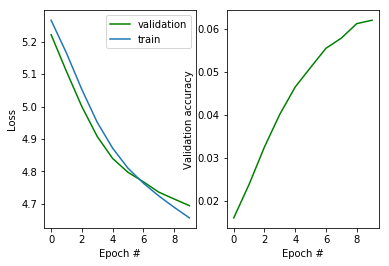

In [ ]:
baseline = BaselineDenseNet()

model = BaselineDenseNet()
model_name = 'baseline_dense'

# Load pre-trained models weights
model = load_model(model, model_name)

lr = 3e-4
bm_baseline, optim, custom_obj = train_model(model, train_batch_gen, val_batch_gen, 
                                             ckpt_name=model_name, 
                                             n_epochs=10)
plot_logs(custom_obj[0])

In [ ]:
# Fimal test
test_model(bm_baseline, test_batch_gen, verbose=False, conf_mx=False)

Results:
  test accuracy:		6.48 %



(0.0647745253164557, nan)

### Good model
**Don't forget to set `aug = True` and reload datasets.**

Better achitecture with dropout between convolutions and some batchnormalization before activation layers. Adam optimizer used instead of SGD. Weight decay helps to regularize model during long training. Scheduler decreases LR to get closer to the optima.

In [ ]:
model = GoodCNN()
model_name = 'good_cnn'

# Load pre-trained models weights
model = load_model(model, model_name)

# Initialuze Conv2 weights (or any other module)
model.apply(weights_init)

lr = 3e-4
opt = torch.optim.Adam(model.parameters(), 
                       lr=lr, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=1e-5) ## !!!

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=5, ## !!!
                                           min_lr=1e-5)

bm_good, optim, custom_obj = train_model(model, train_batch_gen, val_batch_gen, opt,
                                    scheduler=scheduler, ckpt_name=model_name, 
                                    n_epochs=10, verbose=False, annealing=True)
plot_logs(custom_obj[0])

In [ ]:
# Test model
test_model(bm_good, test_batch_gen, verbose=False, conf_mx=False)

### ResNet-16
Pure gold, made from scratch.
Model which scores 42%+ accuracy if trained properly.

Epoch 50 of 50 took 282.820s
  training loss (in-iteration): 	4.382333
  validation accuracy: 			45.88 %
top val accuracy: 45.876


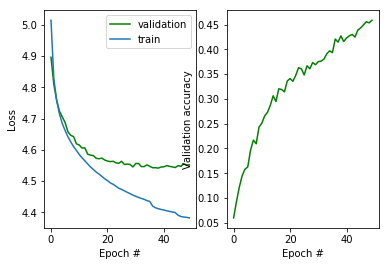

In [ ]:
model = ResNet()
model_name = 'res_net'


# Load pre-trained models weights
# model = load_model(model, model_name)

lr = 3e-4
opt = torch.optim.Adam(model.parameters(), 
                       lr=lr, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=1e-5) ## !!!

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=5, ## !!!
                                           min_lr=1e-5)

bm_resnet, optim, custom_obj = train_model(model, train_batch_gen, val_batch_gen, opt,
                                    scheduler=scheduler, ckpt_name=model_name, 
                                    n_epochs=50, verbose=False, annealing=True)
plot_logs(custom_obj[0])

In [37]:
# Test model
model_name = 'res_net_43'

try:
    with open(MODELS_PATH + model_name, 'rb') as f: model = torch.load(f)
    print("Loaded succesfully!")
except (FileNotFoundError, ) as e:
    print("Pre-trained model not found. Err msg: '{}' ".format(e.args[-1]))

model.to(device)
bm_resnet = model

test_model(bm_resnet, val_batch_gen, verbose=False, conf_mx=False)

Loaded succesfully!


(0.5807950949367089, nan)

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(torch.FloatTensor(X_batch).cuda())
    y_pred = logits.max(1)[1].data
    set_trace()
    test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 40:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 20:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

**Ooops, here is the problem:** in val folder all images are not separated into subfolders and you need to use annotation file and custom Dataset?? for this. Skipped this part


In [ ]:
class TinyImageNetDataset(Dataset):
    """TinyImageNet dataset for validation data."""

    def __init__(self, annotation, root_dir, transform=None):
        """
        Args:
            annotation (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        with open(annotation) as f:
            data = f.readlines()
        
        labels = [x.split('\t')[:2] for x in data]
        
        # labels
        with open('tiny-imagenet-200/wnids.txt') as f:
            class_ids = f.readlines()
        # # val_dataset.targets[]
        class_ids = dict([(y, x) for (x,y) in enumerate([x.split('\n')[0] for x in class_ids])])
        # class_ids['n01629819']
        target = [class_ids[x] for x in labels]


        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# Use 100k examples for training and validation (and testing). There is also 10k images in tiny-imagenet-200/test folder.
# train_dataset = datasets.ImageFolder('tiny-imagenet-200/train', 
#                                transform=complex_transform if aug else transform)

# val_dataset = datasets.DatasetFolder('tiny-imagenet-200/val', 
#                                transform=complex_transform if aug else transform)

test_dataset = datasets.ImageFolder('tiny-imagenet-200/test', transform=transform)

#Save some data for final TEST evaluation
# test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/test', transform=transform)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                              shuffle=True,  num_workers=NUM_WORKERS)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                                            shuffle=True, num_workers=NUM_WORKERS)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                                             shuffle=False,  num_workers=NUM_WORKERS)

# test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=complex_transform)
# test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
#                                              shuffle=False,  num_workers=NUM_WORKERS)
# len(test_dataset)

In [62]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		0.40 %
We need more magic! Follow instructons below


## Fine-tuning

### In practice it is easier to use pre-trained NN


We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly fitting some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)
 

In [33]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
for param in model_resnet18.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
# Sigmoid because originally solved binary classification task. Change
# for logSoftMax or SoftMax in case of multiple classes
model_resnet18.fc = nn.Sequential(nn.Linear(num_ftrs, NUM_CLASSES), nn.Sigmoid())

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

In [ ]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

#### Training (only for final layer)

In [ ]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=3e-4)
ckpt_name_resnet18='model_resnet_18_finetune.ckpt'

model_resnet18, opt_resnet, custom_objects = train_model(model_resnet18,
                                                         train_aug_batch_gen, 
                                                         val_batch_gen,
                                                         opt_resnet,
                                                         ckpt_name=ckpt_name_resnet18,
                                                         n_epochs=EPOCH_NUM * 2)

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]